In [1]:
import mido
import matplotlib.pyplot as plt
import numpy as np
import time

import smart_loop_test

%matplotlib inline

In [2]:
mf = mido.MidiFile('cycle-test.mid')

In [3]:
track = mf.tracks[0]

In [4]:
current_time = 0
note_ons = []
notes = []
for i in range(len(track)):
    current_time = current_time + track[i].time
    #print("{}, time: {}".format(track[i], current_time))
    if(track[i].type == "note_on"):
        note_ons.append(current_time)
        notes.append(track[i].note)

In [5]:
shifts = list(range(0,4000,100))
#p = [smart_loop_test.self_product_shift(note_ons, s, 50) for s in shifts]
#plt.plot(shifts, p)

In [6]:
shifts = list(range(0,4000,100))
#p = [smart_loop_test.labelled_seq_product(note_ons, notes, s, 50) for s in shifts]
#plt.plot(shifts, p)

Neat!, that looks much more interesting. I wonder what all those peaks are?

I'm guessing that the second one is our actual period, where the first one is some sub-pattern that is an almost repetition.

Not sure what the rest are

Oh, duh. They're just harmonics 🤦.   

For a better view, do only the shifts that result in impulse overlap (one of those is guaranteed to be our maximum).

In [7]:
#shifts = smart_loop_test.get_sequence_self_overlaps(np.array(note_ons, dtype=float))
#p = [smart_loop_test.labelled_seq_product(note_ons, notes, s, 50) for s in shifts]
#plt.plot(shifts, p)

In [8]:
len(shifts)

40

Ouch, I think that's quadratic

In [9]:
1900**2

3610000

Well, not worst case anyway.

Need some sense of scale. What's my time unit anyway?

In [10]:
us_per_beat = 500000.0
mf.ticks_per_beat

960

In [11]:
us_per_tick = us_per_beat / mf.ticks_per_beat
us_per_tick

520.8333333333334

In [12]:
note_ons[-1] * us_per_tick / 1E6

181.2421875

That's 3 minutes, which is fairly long. I'd expect the longest loop I'd be interested in supporting would be like 15s, so I need a ~30s buffer to analyze.

In [13]:
ticks_30s = 30E6 * mf.ticks_per_beat / us_per_beat
print(ticks_30s)
i_30s = smart_loop_test.glbi(note_ons, ticks_30s)
print(i_30s)
note_ons[i_30s]
print(note_ons[i_30s])

57600.0
280
57491


Looks good

In [14]:
start = time.time()

shifts,next_is = smart_loop_test.get_sequence_self_overlaps(np.array(note_ons[:i_30s], dtype=float))

finish = time.time()
duration = finish - start
duration

8.951072692871094

Well, that's good so far, what about the rest?

223.80180263519287


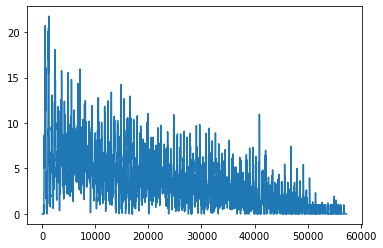

In [15]:
start = time.time()

p = [smart_loop_test.labelled_seq_product(note_ons[:i_30s], notes[:i_30s], s, 50) for s in shifts]

finish = time.time()
duration = finish - start
print(duration)

plt.plot(shifts, p)

Ouch, not great. Probably time to re-write glbi to be a binary search

Without binary-search-glbi it was 868s, so definitely an improvement.

Also, this recording is pretty ridiculous. Definitely at the higher end of note frequency. As well, I currently have all those asserts in there. Not sure how much time that takes up.